In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import jaccard_score
import random
import re

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Dataset Loading and Preprocessing

def numeric_sort_key(path):
    """Sort files based on the number in their filename."""
    filename = os.path.splitext(os.path.basename(path))[0]
    return int(re.findall(r'\d+', filename)[0])

def preprocess_fundus_image(image_path):
    """Load, resize, extract green channel, apply CLAHE, and normalize."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, (512, 512))
    
    green = image[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green)
    
    enhanced = enhanced.astype(np.float32) / 255.0
    enhanced_rgb = np.stack([enhanced] * 3, axis=-1)

    return enhanced_rgb

###BLOODVESSEL SEG
# class FundusVesselDataset(Dataset):
#     """Custom PyTorch Dataset for fundus images and masks."""
#     def __init__(self, image_dir, mask_dir):
#         self.image_paths = sorted([
#             os.path.join(image_dir, f) 
#             for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))
#         ], key=numeric_sort_key)
        
#         self.mask_paths = sorted([
#             os.path.join(mask_dir, f) 
#             for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.jpeg', '.png'))
#         ], key=numeric_sort_key)
        
#         assert len(self.image_paths) == len(self.mask_paths), "Mismatch in number of images and masks!"

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]
        
#         image = preprocess_fundus_image(image_path)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.resize(mask, (512, 512))
#         mask = (mask > 127).astype(np.float32)

#         # Simple augmentations
#         if np.random.rand() > 0.5:
#             image = np.fliplr(image).copy()
#             mask = np.fliplr(mask).copy()
#         if np.random.rand() > 0.5:
#             image = np.flipud(image).copy()
#             mask = np.flipud(mask).copy()

#         image = torch.tensor(image).permute(2, 0, 1)  # [C, H, W]
#         mask = torch.tensor(mask).unsqueeze(0)        # [1, H, W]

#         return image.float(), mask.float()

###OPTICDISKSEG
class FundusVesselDataset(Dataset):
    """
    Custom PyTorch Dataset for fundus images and masks.
    This version explicitly pairs images with their corresponding masks
    and handles different file extensions for images (jpg) and masks (png).
    """
    def __init__(self, image_dir, mask_dir):
        # First, get a sorted list of all image files.
        self.image_paths = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg'))
        ], key=numeric_sort_key)

        self.mask_paths = []
        # For each image, construct and find the corresponding mask file.
        for img_path in self.image_paths:
            # Get the filename without the extension (e.g., "IDRiD_01")
            base_name = os.path.splitext(os.path.basename(img_path))[0]

            mask_name = f"{base_name}_OD.png"
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                self.mask_paths.append(mask_path)
            else:
                print(f"Warning: Mask not found for image {os.path.basename(img_path)}. Expected at: {mask_path}")

        assert len(self.image_paths) == len(self.mask_paths), "Mismatch in number of images and matched masks!"
        print(f"Found and paired {len(self.image_paths)} images and masks.")


    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = preprocess_fundus_image(image_path)
        
        mask_color = cv2.imread(mask_path)
        
        red_channel = mask_color[:, :, 2]
        
        mask = (red_channel > 127).astype(np.float32)

        mask = cv2.resize(mask, (512, 512))

        # Simple augmentations
        if np.random.rand() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()
        if np.random.rand() > 0.5:
            image = np.flipud(image).copy()
            mask = np.flipud(mask).copy()

        image = torch.tensor(image).permute(2, 0, 1)  # Convert to [C, H, W]
        mask = torch.tensor(mask).unsqueeze(0)        # Convert to [1, H, W]

        return image.float(), mask.float()


    def __len__(self):
        return len(self.image_paths)
    
    # def __getitem__(self, idx):
    #     image_path = self.image_paths[idx]
    #     mask_path = self.mask_paths[idx]

    #     image = preprocess_fundus_image(image_path)
    #     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #     mask = cv2.resize(mask, (512, 512))
    #     mask = (mask > 127).astype(np.float32)

    #     # Simple augmentations
    #     if np.random.rand() > 0.5:
    #         image = np.fliplr(image).copy()
    #         mask = np.fliplr(mask).copy()
    #     if np.random.rand() > 0.5:
    #         image = np.flipud(image).copy()
    #         mask = np.flipud(mask).copy()

    #     image = torch.tensor(image).permute(2, 0, 1)  # Convert to [C, H, W]
    #     mask = torch.tensor(mask).unsqueeze(0)        # Convert to [1, H, W]

    #     return image.float(), mask.float()

class ResidualBlock(nn.Module):
    """
    Residual Block with two convolutional layers.
    Includes a 1x1 convolution for the residual connection if channel sizes differ.
    """
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
        )
        self.relu = nn.ReLU(inplace=True)
        self.residual_conv = nn.Conv2d(in_c, out_c, 1, padding=0) if in_c != out_c else nn.Identity()

    def forward(self, x):
        residual = self.residual_conv(x)
        x = self.conv_block(x)
        x += residual
        return self.relu(x)

class AttentionGate(nn.Module):
    """
    Attention Gate to focus on salient features from the skip connection.
    """
    def __init__(self, in_g, in_x, in_c):
        super().__init__()
        self.wg = nn.Conv2d(in_g, in_c, 1)
        self.wx = nn.Conv2d(in_x, in_c, 1)
        self.psi = nn.Sequential(
            nn.Conv2d(in_c, 1, 1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.wg(g)
        x1 = self.wx(x)
        psi_input = self.relu(g1 + x1)
        alpha = self.psi(psi_input)
        return x * alpha

class AttentionResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.d1 = ResidualBlock(3, 64)
        self.d2 = ResidualBlock(64, 128)
        self.d3 = ResidualBlock(128, 256)
        self.d4 = ResidualBlock(256, 512)
        
        self.bottleneck = ResidualBlock(512, 1024)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.ag1 = AttentionGate(512, 512, 512) # g comes from upsampled decoder, x from encoder
        self.u1 = ResidualBlock(1024, 512) # Cat(ag_out, up_out) -> 512+512=1024
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.ag2 = AttentionGate(256, 256, 256)
        self.u2 = ResidualBlock(512, 256) # 256+256=512
        
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.ag3 = AttentionGate(128, 128, 128)
        self.u3 = ResidualBlock(256, 128) # 128+128=256

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.ag4 = AttentionGate(64, 64, 64)
        self.u4 = ResidualBlock(128, 64) # 64+64=128
        
        self.final = nn.Conv2d(64, 1, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoder Path
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        d3 = self.d3(self.pool(d2))
        d4 = self.d4(self.pool(d3))
        
        bn = self.bottleneck(self.pool(d4))

        
        # Level 1
        up_x1 = self.up1(bn)
        attended_d4 = self.ag1(g=up_x1, x=d4)
        x = self.u1(torch.cat([attended_d4, up_x1], dim=1))
        
        # Level 2
        up_x2 = self.up2(x)
        attended_d3 = self.ag2(g=up_x2, x=d3)
        x = self.u2(torch.cat([attended_d3, up_x2], dim=1))

        # Level 3
        up_x3 = self.up3(x)
        attended_d2 = self.ag3(g=up_x3, x=d2)
        x = self.u3(torch.cat([attended_d2, up_x3], dim=1))
        
        # Level 4
        up_x4 = self.up4(x)
        attended_d1 = self.ag4(g=up_x4, x=d1)
        x = self.u4(torch.cat([attended_d1, up_x4], dim=1))
        
        return torch.sigmoid(self.final(x))

#Metrics, Loss, and Visualization

def dice_coeff(pred, target, smooth=1e-6):
    """Calculates the Dice coefficient."""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

###VESSELL SEG IOU
# def iou_score(pred, target):
#     """Calculates the Intersection over Union (Jaccard) score."""
#     pred = (pred > 0.5).cpu().numpy().flatten()
#     target = target.cpu().numpy().flatten()
#     return jaccard_score(target, pred, zero_division=0)

def iou_score(pred, target):
    """Calculates the Intersection over Union (Jaccard) score."""
    pred = (pred > 0.5).cpu().numpy().flatten()
    
    target = target.cpu().numpy().astype(int).flatten()
    
    return jaccard_score(target, pred, zero_division=0)

class DiceLoss(nn.Module):
    """Dice Loss for segmentation."""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        return 1 - ((2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth))

class BCEDiceLoss(nn.Module):
    """Combined BCE and Dice Loss."""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, preds, targets):
        return self.bce(preds, targets) + self.dice(preds, targets)

def visualize_predictions(model, test_loader, n=3):
    """Displays side-by-side comparisons of image, ground truth, and prediction."""
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= n:
                break
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            
            image_np = images[0].cpu().permute(1, 2, 0).numpy()
            mask_np = masks[0][0].cpu().numpy()
            pred_np = preds[0][0].cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(image_np)
            axs[0].set_title("Processed Fundus Image")
            axs[1].imshow(mask_np, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred_np > 0.5, cmap="gray")
            axs[2].set_title("Predicted Mask")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

Found and paired 81 images and masks.


[Epoch 1/150] Training: 100%|██████████| 9/9 [00:40<00:00,  4.55s/it]


Epoch 001: Train Loss=1.5362 | Train Dice=0.3229 | Train IoU=0.2233 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 2/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 002: Train Loss=1.2567 | Train Dice=0.6815 | Train IoU=0.5210 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 3/150] Training: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 003: Train Loss=1.1203 | Train Dice=0.7232 | Train IoU=0.5705 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 4/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 004: Train Loss=0.8592 | Train Dice=0.7745 | Train IoU=0.6352 | Test Dice=0.6743 | Test IoU=0.5437


[Epoch 5/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 005: Train Loss=0.3404 | Train Dice=0.7599 | Train IoU=0.6154 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 6/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 006: Train Loss=0.2957 | Train Dice=0.7556 | Train IoU=0.6150 | Test Dice=0.4925 | Test IoU=0.3520


[Epoch 7/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 007: Train Loss=0.2667 | Train Dice=0.7799 | Train IoU=0.6429 | Test Dice=0.4744 | Test IoU=0.3793


[Epoch 8/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 008: Train Loss=0.2350 | Train Dice=0.8054 | Train IoU=0.6756 | Test Dice=0.1016 | Test IoU=0.0607


[Epoch 9/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 009: Train Loss=0.2562 | Train Dice=0.7853 | Train IoU=0.6512 | Test Dice=0.4133 | Test IoU=0.2774


[Epoch 10/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 010: Train Loss=0.1932 | Train Dice=0.8413 | Train IoU=0.7289 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 11/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 011: Train Loss=0.1979 | Train Dice=0.8347 | Train IoU=0.7197 | Test Dice=0.7757 | Test IoU=0.6704


[Epoch 12/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 012: Train Loss=0.1908 | Train Dice=0.8416 | Train IoU=0.7288 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 13/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 013: Train Loss=0.2006 | Train Dice=0.8339 | Train IoU=0.7161 | Test Dice=0.7455 | Test IoU=0.6676


[Epoch 14/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 014: Train Loss=0.1578 | Train Dice=0.8679 | Train IoU=0.7707 | Test Dice=0.7395 | Test IoU=0.6440


[Epoch 15/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 015: Train Loss=0.1719 | Train Dice=0.8557 | Train IoU=0.7523 | Test Dice=0.0103 | Test IoU=0.0057


[Epoch 16/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 016: Train Loss=0.1937 | Train Dice=0.8378 | Train IoU=0.7250 | Test Dice=0.4107 | Test IoU=0.3297


[Epoch 17/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 017: Train Loss=0.1540 | Train Dice=0.8719 | Train IoU=0.7740 | Test Dice=0.6051 | Test IoU=0.5063


[Epoch 18/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 018: Train Loss=0.1631 | Train Dice=0.8656 | Train IoU=0.7664 | Test Dice=0.6523 | Test IoU=0.5011


[Epoch 19/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 019: Train Loss=0.1461 | Train Dice=0.8789 | Train IoU=0.7884 | Test Dice=0.6302 | Test IoU=0.5612


[Epoch 20/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 020: Train Loss=0.1372 | Train Dice=0.8859 | Train IoU=0.7950 | Test Dice=0.2880 | Test IoU=0.2163


[Epoch 21/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 021: Train Loss=0.1445 | Train Dice=0.8804 | Train IoU=0.7891 | Test Dice=0.7744 | Test IoU=0.6634


[Epoch 22/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 022: Train Loss=0.1158 | Train Dice=0.9044 | Train IoU=0.8272 | Test Dice=0.7537 | Test IoU=0.6771


[Epoch 23/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 023: Train Loss=0.1272 | Train Dice=0.8946 | Train IoU=0.8114 | Test Dice=0.7800 | Test IoU=0.7165


[Epoch 24/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 024: Train Loss=0.1078 | Train Dice=0.9107 | Train IoU=0.8374 | Test Dice=0.0000 | Test IoU=0.0000


[Epoch 25/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 025: Train Loss=0.1264 | Train Dice=0.8962 | Train IoU=0.8137 | Test Dice=0.7953 | Test IoU=0.6994


[Epoch 26/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 026: Train Loss=0.1154 | Train Dice=0.9051 | Train IoU=0.8291 | Test Dice=0.3582 | Test IoU=0.2824


[Epoch 27/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 027: Train Loss=0.1130 | Train Dice=0.9059 | Train IoU=0.8291 | Test Dice=0.8192 | Test IoU=0.7278


[Epoch 28/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 028: Train Loss=0.1184 | Train Dice=0.9020 | Train IoU=0.8237 | Test Dice=0.8321 | Test IoU=0.7555


[Epoch 29/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 029: Train Loss=0.1046 | Train Dice=0.9135 | Train IoU=0.8428 | Test Dice=0.6219 | Test IoU=0.5142


[Epoch 30/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 030: Train Loss=0.0999 | Train Dice=0.9169 | Train IoU=0.8482 | Test Dice=0.5284 | Test IoU=0.4351


[Epoch 31/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 031: Train Loss=0.1003 | Train Dice=0.9167 | Train IoU=0.8472 | Test Dice=0.1345 | Test IoU=0.0862


[Epoch 32/150] Training: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 032: Train Loss=0.1075 | Train Dice=0.9097 | Train IoU=0.8354 | Test Dice=0.8016 | Test IoU=0.7205


[Epoch 33/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 033: Train Loss=0.0892 | Train Dice=0.9256 | Train IoU=0.8627 | Test Dice=0.7431 | Test IoU=0.6626


[Epoch 34/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 034: Train Loss=0.1018 | Train Dice=0.9153 | Train IoU=0.8459 | Test Dice=0.7692 | Test IoU=0.6995


[Epoch 35/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 035: Train Loss=0.0958 | Train Dice=0.9203 | Train IoU=0.8541 | Test Dice=0.8401 | Test IoU=0.7740


[Epoch 36/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 036: Train Loss=0.0900 | Train Dice=0.9255 | Train IoU=0.8627 | Test Dice=0.8032 | Test IoU=0.7274


[Epoch 37/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 037: Train Loss=0.0759 | Train Dice=0.9367 | Train IoU=0.8808 | Test Dice=0.0785 | Test IoU=0.0495


[Epoch 38/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 038: Train Loss=0.0996 | Train Dice=0.9171 | Train IoU=0.8476 | Test Dice=0.8355 | Test IoU=0.7275


[Epoch 39/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 039: Train Loss=0.1010 | Train Dice=0.9172 | Train IoU=0.8486 | Test Dice=0.7277 | Test IoU=0.6407


[Epoch 40/150] Training: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 040: Train Loss=0.0913 | Train Dice=0.9247 | Train IoU=0.8617 | Test Dice=0.3999 | Test IoU=0.3012


[Epoch 41/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 041: Train Loss=0.0848 | Train Dice=0.9293 | Train IoU=0.8696 | Test Dice=0.8252 | Test IoU=0.7579


[Epoch 42/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 042: Train Loss=0.0780 | Train Dice=0.9346 | Train IoU=0.8776 | Test Dice=0.8564 | Test IoU=0.7914


[Epoch 43/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 043: Train Loss=0.0768 | Train Dice=0.9360 | Train IoU=0.8808 | Test Dice=0.8557 | Test IoU=0.7878


[Epoch 44/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 044: Train Loss=0.0783 | Train Dice=0.9344 | Train IoU=0.8779 | Test Dice=0.7862 | Test IoU=0.7285


[Epoch 45/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 045: Train Loss=0.0668 | Train Dice=0.9443 | Train IoU=0.8950 | Test Dice=0.7336 | Test IoU=0.6718


[Epoch 46/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 046: Train Loss=0.0647 | Train Dice=0.9458 | Train IoU=0.8965 | Test Dice=0.7603 | Test IoU=0.6954


[Epoch 47/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 047: Train Loss=0.0604 | Train Dice=0.9492 | Train IoU=0.9036 | Test Dice=0.8111 | Test IoU=0.7569


[Epoch 48/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 048: Train Loss=0.0566 | Train Dice=0.9523 | Train IoU=0.9085 | Test Dice=0.6761 | Test IoU=0.5979


[Epoch 49/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 049: Train Loss=0.0618 | Train Dice=0.9484 | Train IoU=0.9017 | Test Dice=0.8354 | Test IoU=0.7506


[Epoch 50/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 050: Train Loss=0.0788 | Train Dice=0.9337 | Train IoU=0.8757 | Test Dice=0.7646 | Test IoU=0.7207


[Epoch 51/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 051: Train Loss=0.0707 | Train Dice=0.9408 | Train IoU=0.8882 | Test Dice=0.7112 | Test IoU=0.6617


[Epoch 52/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 052: Train Loss=0.0606 | Train Dice=0.9495 | Train IoU=0.9036 | Test Dice=0.7915 | Test IoU=0.7343


[Epoch 53/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 053: Train Loss=0.0624 | Train Dice=0.9478 | Train IoU=0.9014 | Test Dice=0.6052 | Test IoU=0.5240


[Epoch 54/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 054: Train Loss=0.0579 | Train Dice=0.9516 | Train IoU=0.9080 | Test Dice=0.8253 | Test IoU=0.7615


[Epoch 55/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 055: Train Loss=0.0605 | Train Dice=0.9497 | Train IoU=0.9039 | Test Dice=0.7037 | Test IoU=0.6609


[Epoch 56/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 056: Train Loss=0.0828 | Train Dice=0.9312 | Train IoU=0.8711 | Test Dice=0.8353 | Test IoU=0.7608


[Epoch 57/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 057: Train Loss=0.0934 | Train Dice=0.9223 | Train IoU=0.8588 | Test Dice=0.8396 | Test IoU=0.7426


[Epoch 58/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 058: Train Loss=0.0767 | Train Dice=0.9359 | Train IoU=0.8797 | Test Dice=0.8495 | Test IoU=0.7788


[Epoch 59/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 059: Train Loss=0.0927 | Train Dice=0.9220 | Train IoU=0.8560 | Test Dice=0.7963 | Test IoU=0.7290


[Epoch 60/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 060: Train Loss=0.0696 | Train Dice=0.9418 | Train IoU=0.8896 | Test Dice=0.6400 | Test IoU=0.5685


[Epoch 61/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 061: Train Loss=0.0673 | Train Dice=0.9437 | Train IoU=0.8937 | Test Dice=0.7398 | Test IoU=0.6889


[Epoch 62/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 062: Train Loss=0.0517 | Train Dice=0.9572 | Train IoU=0.9179 | Test Dice=0.7005 | Test IoU=0.6460


[Epoch 63/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 063: Train Loss=0.0499 | Train Dice=0.9589 | Train IoU=0.9207 | Test Dice=0.6924 | Test IoU=0.6450


[Epoch 64/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 064: Train Loss=0.0532 | Train Dice=0.9550 | Train IoU=0.9134 | Test Dice=0.8782 | Test IoU=0.8095


[Epoch 65/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 065: Train Loss=0.0487 | Train Dice=0.9596 | Train IoU=0.9228 | Test Dice=0.8746 | Test IoU=0.8086


[Epoch 66/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 066: Train Loss=0.0533 | Train Dice=0.9551 | Train IoU=0.9137 | Test Dice=0.8138 | Test IoU=0.7560


[Epoch 67/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 067: Train Loss=0.0477 | Train Dice=0.9598 | Train IoU=0.9212 | Test Dice=0.8258 | Test IoU=0.7612


[Epoch 68/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 068: Train Loss=0.0484 | Train Dice=0.9593 | Train IoU=0.9215 | Test Dice=0.8303 | Test IoU=0.7656


[Epoch 69/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 069: Train Loss=0.0462 | Train Dice=0.9612 | Train IoU=0.9253 | Test Dice=0.8327 | Test IoU=0.7722


[Epoch 70/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 070: Train Loss=0.0427 | Train Dice=0.9641 | Train IoU=0.9303 | Test Dice=0.7567 | Test IoU=0.7103


[Epoch 71/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 071: Train Loss=0.0447 | Train Dice=0.9628 | Train IoU=0.9286 | Test Dice=0.7018 | Test IoU=0.6480


[Epoch 72/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 072: Train Loss=0.0522 | Train Dice=0.9561 | Train IoU=0.9154 | Test Dice=0.8197 | Test IoU=0.7644


[Epoch 73/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 073: Train Loss=0.0486 | Train Dice=0.9594 | Train IoU=0.9223 | Test Dice=0.7477 | Test IoU=0.6884


[Epoch 74/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 074: Train Loss=0.0555 | Train Dice=0.9533 | Train IoU=0.9102 | Test Dice=0.8481 | Test IoU=0.7920


[Epoch 75/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 075: Train Loss=0.0524 | Train Dice=0.9558 | Train IoU=0.9157 | Test Dice=0.8471 | Test IoU=0.7895


[Epoch 76/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 076: Train Loss=0.0442 | Train Dice=0.9629 | Train IoU=0.9286 | Test Dice=0.8827 | Test IoU=0.8193


[Epoch 77/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 077: Train Loss=0.0457 | Train Dice=0.9619 | Train IoU=0.9268 | Test Dice=0.8755 | Test IoU=0.8148


[Epoch 78/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 078: Train Loss=0.0448 | Train Dice=0.9623 | Train IoU=0.9269 | Test Dice=0.8160 | Test IoU=0.7571


[Epoch 79/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 079: Train Loss=0.0430 | Train Dice=0.9637 | Train IoU=0.9293 | Test Dice=0.8021 | Test IoU=0.7491


[Epoch 80/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 080: Train Loss=0.0458 | Train Dice=0.9613 | Train IoU=0.9255 | Test Dice=0.8238 | Test IoU=0.7787


[Epoch 81/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 081: Train Loss=0.0449 | Train Dice=0.9622 | Train IoU=0.9274 | Test Dice=0.8606 | Test IoU=0.8061


[Epoch 82/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 082: Train Loss=0.0406 | Train Dice=0.9657 | Train IoU=0.9337 | Test Dice=0.8789 | Test IoU=0.8178


[Epoch 83/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 083: Train Loss=0.0401 | Train Dice=0.9662 | Train IoU=0.9343 | Test Dice=0.8599 | Test IoU=0.8027


[Epoch 84/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 084: Train Loss=0.0432 | Train Dice=0.9637 | Train IoU=0.9302 | Test Dice=0.8516 | Test IoU=0.7975


[Epoch 85/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 085: Train Loss=0.0368 | Train Dice=0.9691 | Train IoU=0.9399 | Test Dice=0.8442 | Test IoU=0.7755


[Epoch 86/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 086: Train Loss=0.0394 | Train Dice=0.9669 | Train IoU=0.9358 | Test Dice=0.7746 | Test IoU=0.7246


[Epoch 87/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 087: Train Loss=0.0379 | Train Dice=0.9681 | Train IoU=0.9377 | Test Dice=0.7657 | Test IoU=0.7209


[Epoch 88/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 088: Train Loss=0.0429 | Train Dice=0.9640 | Train IoU=0.9308 | Test Dice=0.6208 | Test IoU=0.5209


[Epoch 89/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 089: Train Loss=0.0589 | Train Dice=0.9510 | Train IoU=0.9059 | Test Dice=0.8584 | Test IoU=0.8006


[Epoch 90/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 090: Train Loss=0.0615 | Train Dice=0.9483 | Train IoU=0.9017 | Test Dice=0.7785 | Test IoU=0.7077


[Epoch 91/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 091: Train Loss=0.0574 | Train Dice=0.9516 | Train IoU=0.9080 | Test Dice=0.7759 | Test IoU=0.7126


[Epoch 92/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 092: Train Loss=0.0462 | Train Dice=0.9615 | Train IoU=0.9263 | Test Dice=0.7307 | Test IoU=0.6719


[Epoch 93/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 093: Train Loss=0.0427 | Train Dice=0.9643 | Train IoU=0.9303 | Test Dice=0.8533 | Test IoU=0.7910


[Epoch 94/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 094: Train Loss=0.0424 | Train Dice=0.9644 | Train IoU=0.9320 | Test Dice=0.8164 | Test IoU=0.7550


[Epoch 95/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 095: Train Loss=0.0407 | Train Dice=0.9657 | Train IoU=0.9336 | Test Dice=0.7896 | Test IoU=0.7385


[Epoch 96/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 096: Train Loss=0.0396 | Train Dice=0.9666 | Train IoU=0.9347 | Test Dice=0.7922 | Test IoU=0.7382


[Epoch 97/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 097: Train Loss=0.0368 | Train Dice=0.9690 | Train IoU=0.9392 | Test Dice=0.8821 | Test IoU=0.8233


[Epoch 98/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 098: Train Loss=0.0391 | Train Dice=0.9672 | Train IoU=0.9370 | Test Dice=0.8713 | Test IoU=0.8065


[Epoch 99/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 099: Train Loss=0.0346 | Train Dice=0.9707 | Train IoU=0.9428 | Test Dice=0.8356 | Test IoU=0.7907


[Epoch 100/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 100: Train Loss=0.0351 | Train Dice=0.9706 | Train IoU=0.9427 | Test Dice=0.8817 | Test IoU=0.8227


[Epoch 101/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 101: Train Loss=0.0378 | Train Dice=0.9683 | Train IoU=0.9386 | Test Dice=0.8821 | Test IoU=0.8214


[Epoch 102/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 102: Train Loss=0.0334 | Train Dice=0.9721 | Train IoU=0.9454 | Test Dice=0.8553 | Test IoU=0.8016


[Epoch 103/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 103: Train Loss=0.0313 | Train Dice=0.9739 | Train IoU=0.9491 | Test Dice=0.8499 | Test IoU=0.7976


[Epoch 104/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 104: Train Loss=0.0344 | Train Dice=0.9709 | Train IoU=0.9430 | Test Dice=0.8571 | Test IoU=0.8056


[Epoch 105/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 105: Train Loss=0.0329 | Train Dice=0.9723 | Train IoU=0.9464 | Test Dice=0.8865 | Test IoU=0.8301


[Epoch 106/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 106: Train Loss=0.0343 | Train Dice=0.9709 | Train IoU=0.9428 | Test Dice=0.8902 | Test IoU=0.8282


[Epoch 107/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 107: Train Loss=0.0336 | Train Dice=0.9719 | Train IoU=0.9457 | Test Dice=0.8223 | Test IoU=0.7785


[Epoch 108/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 108: Train Loss=0.0335 | Train Dice=0.9720 | Train IoU=0.9446 | Test Dice=0.8362 | Test IoU=0.7888


[Epoch 109/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 109: Train Loss=0.0329 | Train Dice=0.9724 | Train IoU=0.9457 | Test Dice=0.8537 | Test IoU=0.8015


[Epoch 110/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 110: Train Loss=0.0333 | Train Dice=0.9719 | Train IoU=0.9456 | Test Dice=0.8619 | Test IoU=0.8128


[Epoch 111/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 111: Train Loss=0.0320 | Train Dice=0.9731 | Train IoU=0.9477 | Test Dice=0.8545 | Test IoU=0.8024


[Epoch 112/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 112: Train Loss=0.0296 | Train Dice=0.9751 | Train IoU=0.9508 | Test Dice=0.8755 | Test IoU=0.8106


[Epoch 113/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 113: Train Loss=0.0336 | Train Dice=0.9718 | Train IoU=0.9455 | Test Dice=0.8359 | Test IoU=0.7898


[Epoch 114/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 114: Train Loss=0.0366 | Train Dice=0.9690 | Train IoU=0.9390 | Test Dice=0.7989 | Test IoU=0.7457


[Epoch 115/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 115: Train Loss=0.0364 | Train Dice=0.9696 | Train IoU=0.9416 | Test Dice=0.8759 | Test IoU=0.8183


[Epoch 116/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 116: Train Loss=0.0387 | Train Dice=0.9674 | Train IoU=0.9367 | Test Dice=0.8937 | Test IoU=0.8194


[Epoch 117/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 117: Train Loss=0.0433 | Train Dice=0.9634 | Train IoU=0.9293 | Test Dice=0.6117 | Test IoU=0.5247


[Epoch 118/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 118: Train Loss=0.0532 | Train Dice=0.9551 | Train IoU=0.9134 | Test Dice=0.8623 | Test IoU=0.8036


[Epoch 119/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 119: Train Loss=0.0481 | Train Dice=0.9596 | Train IoU=0.9227 | Test Dice=0.7736 | Test IoU=0.7304


[Epoch 120/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 120: Train Loss=0.0448 | Train Dice=0.9623 | Train IoU=0.9272 | Test Dice=0.8495 | Test IoU=0.7808


[Epoch 121/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 121: Train Loss=0.0422 | Train Dice=0.9643 | Train IoU=0.9310 | Test Dice=0.8846 | Test IoU=0.8244


[Epoch 122/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 122: Train Loss=0.0373 | Train Dice=0.9687 | Train IoU=0.9388 | Test Dice=0.8394 | Test IoU=0.7938


[Epoch 123/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 123: Train Loss=0.0355 | Train Dice=0.9703 | Train IoU=0.9429 | Test Dice=0.8260 | Test IoU=0.7833


[Epoch 124/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 124: Train Loss=0.0328 | Train Dice=0.9722 | Train IoU=0.9450 | Test Dice=0.8264 | Test IoU=0.7725


[Epoch 125/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 125: Train Loss=0.0333 | Train Dice=0.9720 | Train IoU=0.9458 | Test Dice=0.8315 | Test IoU=0.7792


[Epoch 126/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 126: Train Loss=0.0348 | Train Dice=0.9706 | Train IoU=0.9421 | Test Dice=0.7568 | Test IoU=0.7090


[Epoch 127/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 127: Train Loss=0.0332 | Train Dice=0.9720 | Train IoU=0.9453 | Test Dice=0.8324 | Test IoU=0.7881


[Epoch 128/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 128: Train Loss=0.0320 | Train Dice=0.9731 | Train IoU=0.9477 | Test Dice=0.8347 | Test IoU=0.7913


[Epoch 129/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 129: Train Loss=0.0341 | Train Dice=0.9711 | Train IoU=0.9434 | Test Dice=0.8233 | Test IoU=0.7803


[Epoch 130/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Epoch 130: Train Loss=0.0313 | Train Dice=0.9737 | Train IoU=0.9487 | Test Dice=0.8410 | Test IoU=0.7967


[Epoch 131/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 131: Train Loss=0.0335 | Train Dice=0.9717 | Train IoU=0.9449 | Test Dice=0.8329 | Test IoU=0.7961


[Epoch 132/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 132: Train Loss=0.0317 | Train Dice=0.9733 | Train IoU=0.9471 | Test Dice=0.8128 | Test IoU=0.7633


[Epoch 133/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 133: Train Loss=0.0317 | Train Dice=0.9732 | Train IoU=0.9478 | Test Dice=0.8303 | Test IoU=0.7835


[Epoch 134/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 134: Train Loss=0.0298 | Train Dice=0.9748 | Train IoU=0.9503 | Test Dice=0.7959 | Test IoU=0.7447


[Epoch 135/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 135: Train Loss=0.0300 | Train Dice=0.9748 | Train IoU=0.9511 | Test Dice=0.8471 | Test IoU=0.8021


[Epoch 136/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


Epoch 136: Train Loss=0.0282 | Train Dice=0.9762 | Train IoU=0.9535 | Test Dice=0.8338 | Test IoU=0.7909


[Epoch 137/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


Epoch 137: Train Loss=0.0304 | Train Dice=0.9744 | Train IoU=0.9495 | Test Dice=0.7822 | Test IoU=0.7369


[Epoch 138/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


Epoch 138: Train Loss=0.0298 | Train Dice=0.9748 | Train IoU=0.9505 | Test Dice=0.8234 | Test IoU=0.7732


[Epoch 139/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 139: Train Loss=0.0308 | Train Dice=0.9741 | Train IoU=0.9495 | Test Dice=0.8355 | Test IoU=0.7944


[Epoch 140/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 140: Train Loss=0.0284 | Train Dice=0.9761 | Train IoU=0.9536 | Test Dice=0.8658 | Test IoU=0.8174


[Epoch 141/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 141: Train Loss=0.0284 | Train Dice=0.9761 | Train IoU=0.9527 | Test Dice=0.8622 | Test IoU=0.8121


[Epoch 142/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 142: Train Loss=0.0315 | Train Dice=0.9733 | Train IoU=0.9477 | Test Dice=0.8222 | Test IoU=0.7784


[Epoch 143/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 143: Train Loss=0.0276 | Train Dice=0.9766 | Train IoU=0.9538 | Test Dice=0.8408 | Test IoU=0.7914


[Epoch 144/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 144: Train Loss=0.0298 | Train Dice=0.9749 | Train IoU=0.9509 | Test Dice=0.8559 | Test IoU=0.8067


[Epoch 145/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 145: Train Loss=0.0276 | Train Dice=0.9766 | Train IoU=0.9542 | Test Dice=0.8270 | Test IoU=0.7801


[Epoch 146/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 146: Train Loss=0.0288 | Train Dice=0.9757 | Train IoU=0.9521 | Test Dice=0.8247 | Test IoU=0.7821


[Epoch 147/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 147: Train Loss=0.0302 | Train Dice=0.9745 | Train IoU=0.9504 | Test Dice=0.8397 | Test IoU=0.7985


[Epoch 148/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Epoch 148: Train Loss=0.0292 | Train Dice=0.9754 | Train IoU=0.9523 | Test Dice=0.8317 | Test IoU=0.7926


[Epoch 149/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 149: Train Loss=0.0291 | Train Dice=0.9754 | Train IoU=0.9520 | Test Dice=0.8523 | Test IoU=0.8040


[Epoch 150/150] Training: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 150: Train Loss=0.0330 | Train Dice=0.9721 | Train IoU=0.9454 | Test Dice=0.8269 | Test IoU=0.7820


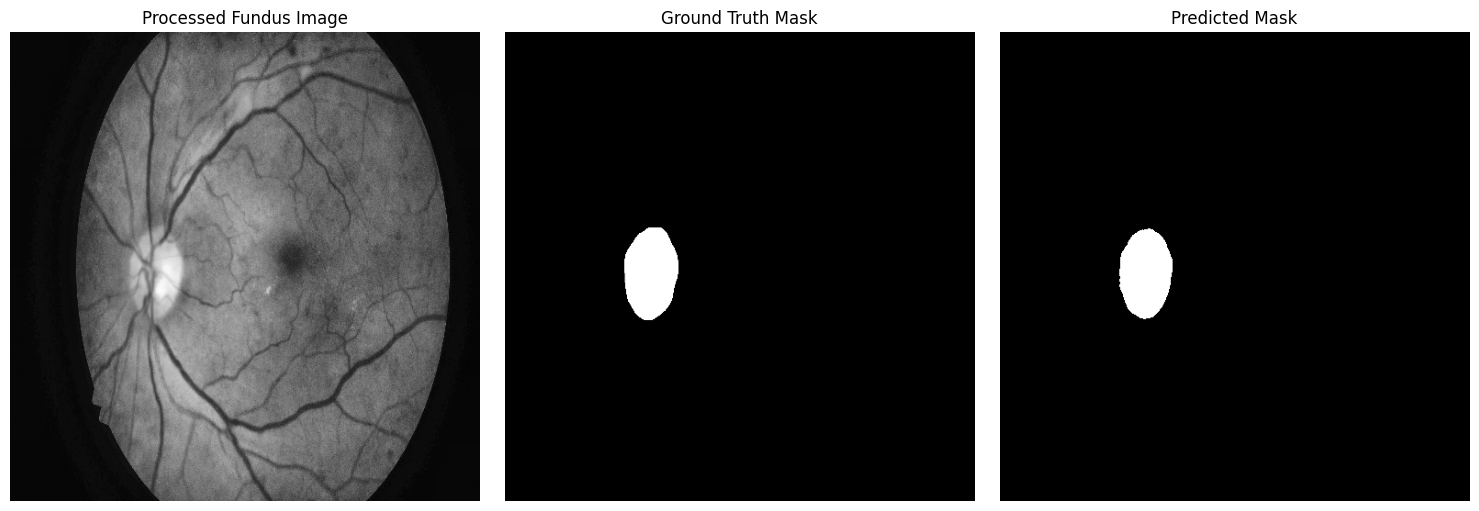

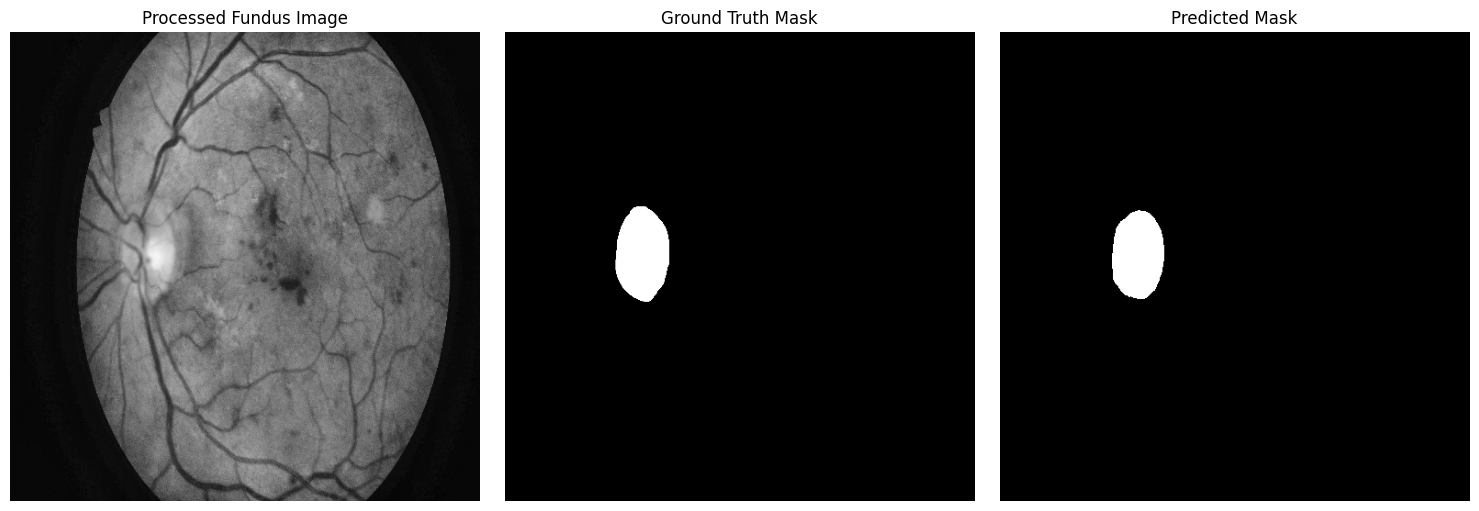

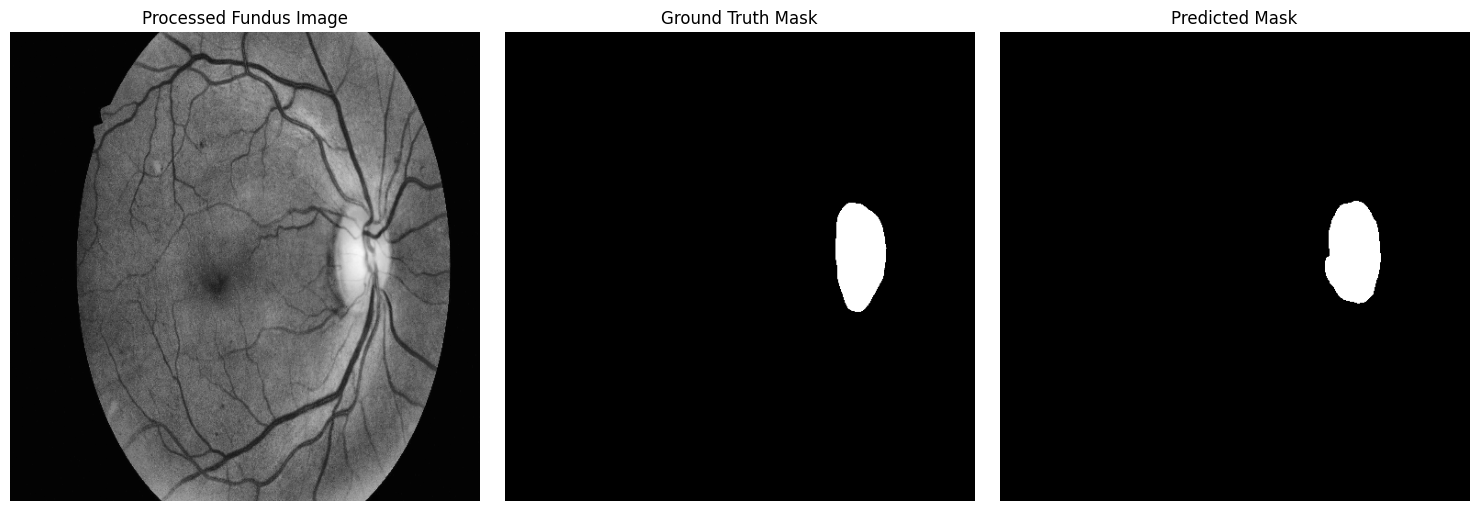

In [1]:

#train

def train_model(image_dir, mask_dir, epochs=150, batch_size=8, lr=1e-4, test_ratio=0.2):
    """Main function to handle dataset splitting, training, and evaluation."""
    dataset = FundusVesselDataset(image_dir, mask_dir)

    test_size = int(len(dataset) * test_ratio)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    

    model = AttentionResUNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = BCEDiceLoss()

    for epoch in range(epochs):
        model.train()
        train_loss, train_dice, train_iou = 0, 0, 0
        for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{epochs}] Training"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice_coeff(preds, masks).item()
            train_iou += iou_score(preds, masks)

        # Evaluation on test set
        model.eval()
        test_dice, test_iou = 0, 0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                test_dice += dice_coeff(preds, masks).item()
                test_iou += iou_score(preds, masks)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_test_dice = test_dice / len(test_loader)
        avg_test_iou = test_iou / len(test_loader)
        
        print(f"Epoch {epoch+1:03d}: "
              f"Train Loss={avg_train_loss:.4f} | "
              f"Train Dice={avg_train_dice:.4f} | "
              f"Train IoU={avg_train_iou:.4f} | "
              f"Test Dice={avg_test_dice:.4f} | "
              f"Test IoU={avg_test_iou:.4f}")

    torch.save(model.state_dict(), "attention_res_unet_optic_disk.pth")
    # torch.save(model.state_dict(), "attention_res_unet_bloodvessel.pth")
    # print("\nModel saved as 'attention_res_unet_bloodvessel.pth'")

    # Visualize some predictions
    visualize_predictions(model, test_loader, n=3)
    return model

if __name__ == "__main__":
    image_dir = "opticDiskSeg/images"
    mask_dir = "opticDiskSeg/masks"
    
    #trained_model = train_model(image_dir, mask_dir)

In [5]:
def predict(model, image_path, device):
    """
    Runs inference on a single image using the provided model.
    """
    processed_image = preprocess_fundus_image(image_path)

    # Format: [Batch, Channels, Height, Width]
    img_tensor = torch.tensor(processed_image).permute(2, 0, 1).unsqueeze(0).to(device)

    model.eval()

    # Perform inference without calculating gradients
    with torch.no_grad():
        prediction_tensor = model(img_tensor)


    predicted_mask = prediction_tensor.squeeze().cpu().numpy()

    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    return binary_mask

Model loaded successfully.
Inference complete.


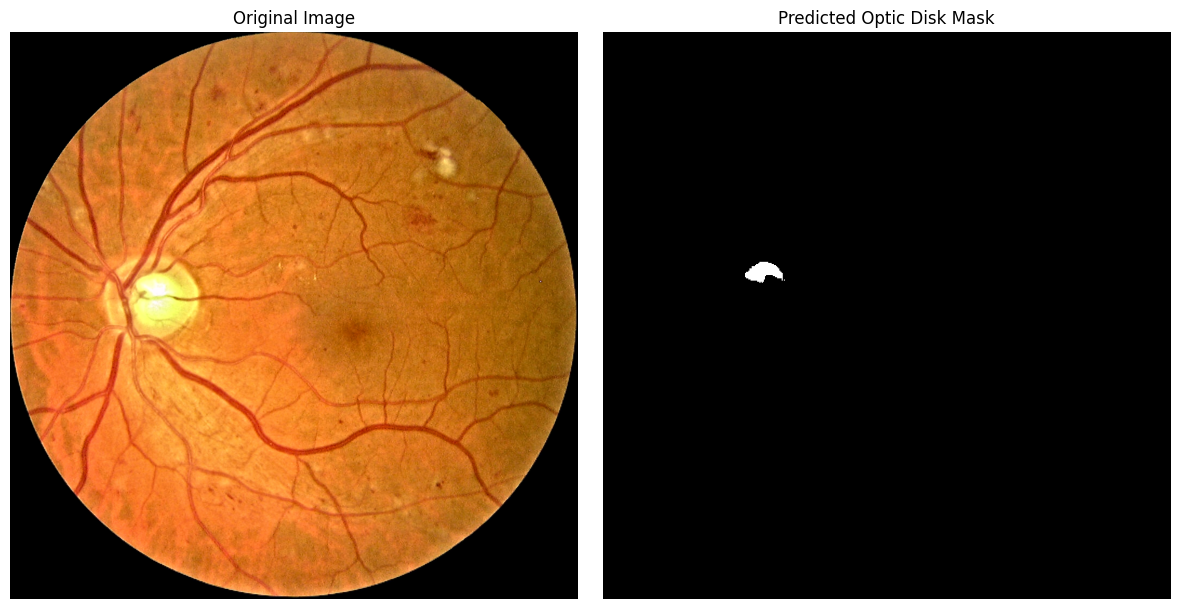

In [8]:
MODEL_PATH = "attention_res_unet_optic_disk.pth"  
IMAGE_PATH = "0025_3.png"    

# Initialize the model and load the trained weights
model = AttentionResUNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print("Model loaded successfully.")

predicted_mask = predict(model, IMAGE_PATH, device)
print("Inference complete.")

original_image = cv2.imread(IMAGE_PATH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # for matplotlib

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(predicted_mask, cmap="gray")
axs[1].set_title("Predicted Optic Disk Mask")
axs[1].axis("off")

plt.tight_layout()
plt.show()